# LSTM Intent Classification



**Dataset:** Intent

**Model:**   multiclass classification model : LSTM

**Training:**  Colab (GPU)  

**Process:**  1. Dataset Load  ➔ 2. Data processing ➔ 3. Model Training  ➔ 4. Model Evaluation ➔ 5. Prediction

**Result:**  Accuracy = 0.78, run time = 3 minutes

## ライブラリ

In [1]:
#　ライブラリ

import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## 1. データ読み込

In [2]:
# google driveと接続

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 入力データを確認

!ls '/content/drive/My Drive/dataset/chat_intent1/'

Dataset.csv


In [0]:
# intent, unique_intent, sentencesに分ける

def load_dataset(filename):
  df = pd.read_csv(filename, encoding = "latin1", names = ["Sentence", "Intent"])
  print(df.head())
  intent = df["Intent"]
  unique_intent = list(set(intent))
  sentences = list(df["Sentence"])
  
  return (df, intent, unique_intent, sentences)

In [5]:
# データ読み込

dataset = "/content/drive/My Drive/dataset/chat_intent1/Dataset.csv"
data, intent, unique_intent, sentences = load_dataset(dataset)

                Sentence          Intent
0       Need help pleese  commonQ.assist
1              Need help  commonQ.assist
2       I need some info  commonQ.assist
3      Will you help me?  commonQ.assist
4  What else can you do?  commonQ.assist


In [6]:
# サンプルデータを確認

print(sentences[:5])

['Need help pleese', 'Need help', 'I need some info', 'Will you help me?', 'What else can you do?']


## 2. データ準備

In [7]:
# nltkのstopwordsとtokenizersを読み込む

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
#define stemmer
stemmer = LancasterStemmer()

In [9]:
# データクリーニング

def cleaning(sentences):
  words = []
  for s in sentences:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
    w = word_tokenize(clean)
    #stemming
    words.append([i.lower() for i in w])
    
  return words

cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])  

1113
[['need', 'help', 'pleese'], ['need', 'help']]


In [10]:
# Tokenizerを作成

def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

# max_lengthの設定
def max_length(words):
  return(len(max(words, key = len)))


word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 492 and Maximum length = 28


In [0]:
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

padded_doc = padding_doc(encoded_doc, max_length)

In [12]:
padded_doc[:5]

array([[ 25,  77, 332,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 25,  77,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  1,  25, 198, 181,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 51,  10,  77,  16,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  8, 268,   4,  10,  30,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int32)

In [13]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (1113, 28)


In [0]:
# tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')


In [15]:
output_tokenizer.word_index

{'commonq.assist': 6,
 'commonq.bot': 8,
 'commonq.how': 14,
 'commonq.just_details': 9,
 'commonq.name': 4,
 'commonq.not_giving': 2,
 'commonq.query': 20,
 'commonq.wait': 12,
 'contact.contact': 5,
 'faq.aadhaar_missing': 18,
 'faq.address_proof': 21,
 'faq.application_process': 17,
 'faq.apply_register': 10,
 'faq.approval_time': 19,
 'faq.bad_service': 16,
 'faq.banking_option_missing': 7,
 'faq.biz_category_missing': 15,
 'faq.biz_new': 1,
 'faq.biz_simpler': 13,
 'faq.borrow_limit': 3,
 'faq.borrow_use': 11}

In [16]:
# Tokenizer

encoded_output = encoding_doc(output_tokenizer, intent)

encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

encoded_output.shape

(1113, 1)

In [17]:
# one hot encoder

def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

output_one_hot = one_hot(encoded_output)

output_one_hot.shape

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(1113, 21)

In [18]:
# 学習とテストを分ける

from sklearn.model_selection import train_test_split

train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)

print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))


Shape of train_X = (890, 28) and train_Y = (890, 21)
Shape of val_X = (223, 28) and val_Y = (223, 21)


## 3. 学習

In [19]:
# モデルの設定

def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128)))
#   model.add(LSTM(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(21, activation = "softmax"))
  
  return model

model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

W0727 12:02:12.871113 140700909479808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 12:02:12.892578 140700909479808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 12:02:12.896677 140700909479808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 12:02:13.568534 140700909479808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0727 12:02:13.583393 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 128)           62976     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 21)                693       
Total params: 335,061
Trainable params: 272,085
Non-trainable params: 62,976
_________________________________________________________________


In [20]:
# モデル学習
from datetime import datetime

start_time = datetime.now()

filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hist = model.fit(train_X, train_Y, epochs = 100, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

W0727 12:02:13.811845 140700909479808 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 890 samples, validate on 223 samples
Epoch 1/100
890/890 [==============================] - 4s 5ms/step - loss: 2.9907 - acc: 0.0944 - val_loss: 2.8273 - val_acc: 0.1839

Epoch 00001: val_loss improved from inf to 2.82733, saving model to model.h5
Epoch 2/100
890/890 [==============================] - 2s 3ms/step - loss: 2.8966 - acc: 0.1236 - val_loss: 2.7746 - val_acc: 0.2287

Epoch 00002: val_loss improved from 2.82733 to 2.77456, saving model to model.h5
Epoch 3/100
890/890 [==============================] - 2s 3ms/step - loss: 2.8424 - acc: 0.1528 - val_loss: 2.6552 - val_acc: 0.2287

Epoch 00003: val_loss improved from 2.77456 to 2.65522, saving model to model.h5
Epoch 4/100
890/890 [==============================] - 2s 2ms/step - loss: 2.7216 - acc: 0.1584 - val_loss: 2.4619 - val_acc: 0.2287

Epoch 00004: val_loss improved from 2.65522 to 2.46192, saving model to model.h5
Epoch 5/100
890/890 [==============================] - 2s 2ms/step - loss: 2.6358 - acc: 0.1910 - 

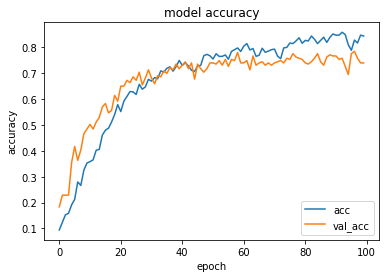

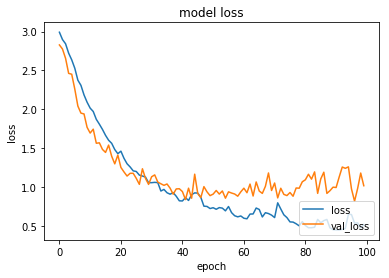

In [21]:
def plot_history(hist):
    #print(hist.history.keys())

    # 精度の履歴をプロット
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    # 損失の履歴をプロット
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

# 学習履歴をプロット
plot_history(hist)

In [0]:
# モデルの設定

model = load_model("model.h5")

In [0]:
#ytest = np.array(y_test)
ytest = np.argmax(val_Y, axis=1)
pd = model.predict(val_X)
prediction = pd.argmax(1)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

#ytest = np.array(val_Y)
ytest = np.argmax(val_Y, axis=1)
pd = model.predict(val_X)
prediction = pd.argmax(1)


# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, prediction))
print(confusion_matrix(ytest, prediction))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.50      1.00      0.67         1
           2       0.93      0.81      0.87        16
           3       0.00      0.00      0.00         5
           4       0.74      0.90      0.81        31
           5       0.67      0.33      0.44         6
           6       0.83      1.00      0.91         5
           7       0.00      0.00      0.00         2
           9       0.71      0.48      0.57        21
          10       0.77      0.96      0.85        24
          11       0.00      0.00      0.00         3
          12       0.81      0.87      0.84        15
          14       1.00      1.00      1.00         8
          15       0.00      0.00      0.00         3
          16       0.82      0.90      0.86        51
          17       1.00      0.75      0.86         4
          18       1.00      1.00      1.00        10
          19       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
from sklearn.metrics import accuracy_score


accuracy = accuracy_score(ytest, prediction)
accuracy

0.7847533632286996

## 4. 推論

In [0]:
# 推論のスクリプト

def predictions(text):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)
  print(test_word)
  #Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
  x = padding_doc(test_ls, max_length)
  
  pred = model.predict_proba(x)
  
  return pred


def get_final_output(pred, classes):
  predictions = pred[0]
 
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
 
  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))


In [27]:
# テスト

text = "What is your name?"
pred = predictions(text)
get_final_output(pred, unique_intent)

['what', 'is', 'your', 'name']
commonQ.bot has confidence = 0.19591697
contact.contact has confidence = 0.14024183
commonQ.name has confidence = 0.12911913
commonQ.assist has confidence = 0.11486291
commonQ.how has confidence = 0.09255718
commonQ.not_giving has confidence = 0.05841762
faq.bad_service has confidence = 0.051745627
faq.borrow_limit has confidence = 0.033093505
commonQ.wait has confidence = 0.029392822
commonQ.query has confidence = 0.02901133
commonQ.just_details has confidence = 0.026631303
faq.apply_register has confidence = 0.02225921
faq.biz_new has confidence = 0.017793031
faq.aadhaar_missing has confidence = 0.012081558
faq.borrow_use has confidence = 0.011732864
faq.biz_simpler has confidence = 0.010548913
faq.banking_option_missing has confidence = 0.007455135
faq.application_process has confidence = 0.007389313
faq.address_proof has confidence = 0.004451722
faq.biz_category_missing has confidence = 0.0039024767
faq.approval_time has confidence = 0.0013955322
